# Project - Day 1 - Practicing with Cygno data and docker 🦢🐳

## Introduction
The aim of the CYGNO project is to prove the capability of a high resolution gaseous TPC with sCMOS (scientific CMOS) optical readout for near future directional Dark Matter searches at low 1-10 GeV WIMP masses down to and beyond the Neutrino Floor. CYGNO consists of one cubic meter demonstrator to be installed at LNGS aiming to show the following performances and capabilities:
 
 * O(keV) energy threshold on nuclear recoil tracks;
 * 3d tracking reconstruction with head-tail determination;
 * 3d detector fiducialization;
 * Electron rejection power of $10^5$;
 * Complete background rejection thanks to the very good particle detection and identification;
 * Operate light target, such as He-based gas mixtures;
 * High sensitivity to 1-10 GeV WIMP mass region

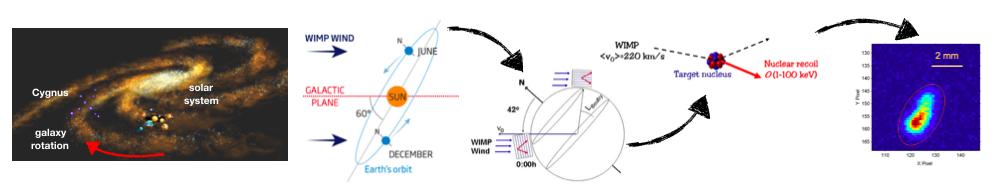



In this first warm-up exercise we will develop the preprocessing step, selecting the most relevant part of the image (both in terms of space and pixel volume range).

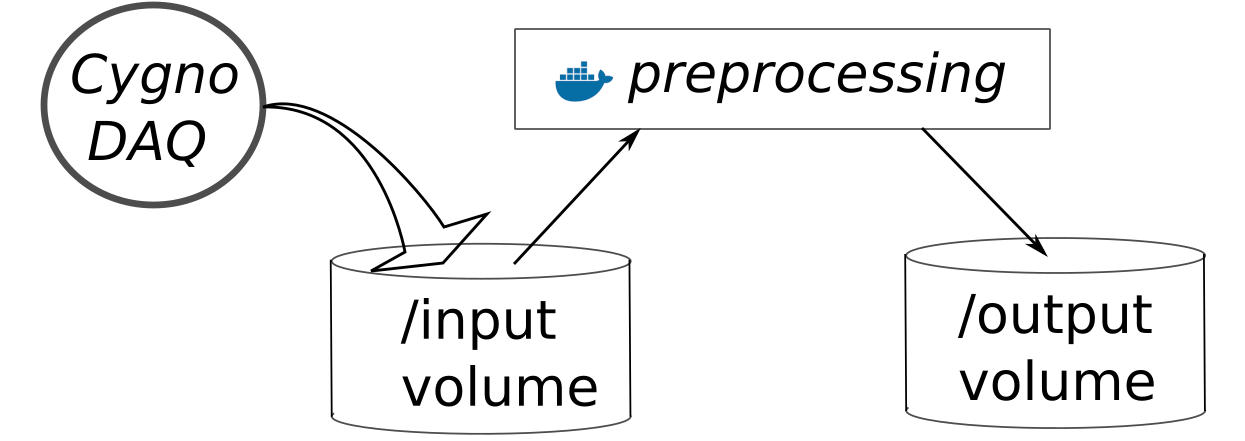

This conceptual procedure, while rather simplified in the operations executed, is very common in real experiments. Instead of a preprocessing step you may have a reconstruction or an online selection step, or a compression or whatever is worth to avoid storing the whole amount of acquired data for offline processing.

The implementation, instead, is very basic as we aim to expose to you the fundamental building blocks before discussing turnkey solutions (that we will do before the end of the school!)
 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os


The dataset we are using was obtained by simulating WIMP and electon recoils in the target vessel with Geant 4, and then acquiring the image.

Let's start by downloading the simulated datasets from an INFN repository and let's unzip it.

In [2]:
!mkdir -p ${HOME}/data
!wget --no-check-certificate https://131.154.96.57:9000/sosc/training_set.zip -O ${HOME}/training_set.zip
!cd ${HOME}; unzip -qn ${HOME}/training_set.zip 

--2023-10-23 15:13:45--  https://131.154.96.57:9000/sosc/training_set.zip
Connecting to 131.154.96.57:9000... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 109878633 (105M) [application/zip]
Saving to: ‘/home/jovyan/training_set.zip’

/home/jovyan/traini 100%[===================>] 104.79M  53.1MB/s    in 2.0s    

2023-10-23 15:13:47 (53.1 MB/s) - ‘/home/jovyan/training_set.zip’ saved [109878633/109878633]



We can use the glob module (part of the Python Standard Libraries) to list the files we have downloaded and the directory structure.

Here, we limit ourselves to 10 files, but you can list all of them 😋

In [15]:
from glob import glob
input_files = glob ("/home/jovyan/data/export/train/*/*/*.png")
input_files[:10]

['/home/jovyan/data/export/train/NR/20_keV/cygno-0041.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0034.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0021.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0100.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0066.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0006.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0003.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0084.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0086.png',
 '/home/jovyan/data/export/train/NR/20_keV/cygno-0011.png']

### Exercise 1 - Obtain information from the path -⌛
Let's define two functions to determine whether the considered file was generated as a nuclear (NR) or an electronic (ER) recoil, and to determine the simulated energy from the path.

The first one is given...

In [16]:
def get_recoil_type(filename):
    """
    Return the strings "nuclear" or "electronic" if the file is 
    located in a subdir of "NR" or "ER", respectively.
    Return None otherwise.
    """
    if "NR" in filename.split("/"):
        return 'nuclear'
    if "ER" in filename.split("/"):
        return "electronic"
    return None

## Example
get_recoil_type(input_files[0])

'nuclear'

The second is up to you.
> **💡 Hint.** You may want to start with:
> ```python
> def get_energy_keV(filename):
>   """Return the energy in keV as a float as obtained parsing filename"""
>   #... your code here ...
> ```
> 
> Also, check:
>  * the [`str.split`](https://docs.python.org/3.11/library/stdtypes.html#str.split) method
>  * usage of the `in` operator for *membership testing* (e.g. on [tutorialspoint.com](https://www.tutorialspoint.com/python/membership_operators_example.htm))
>  * string slicing (e.g. on [realpython.com](https://realpython.com/python-strings/#string-slicing))

In [17]:
def get_energy_keV(filename):
  """Return the energy in keV as a float as obtained parsing filename"""

  meta=filename.split('_')
  return meta[0].split('/')[-1]
  


get_energy_keV(input_files[100])

'3'

## Exercise 2 - Load and draw a datafile using pillow -⌛
Using pillow (`import PIL`) you can load and display an image.

You should expect something on the line of the following figure
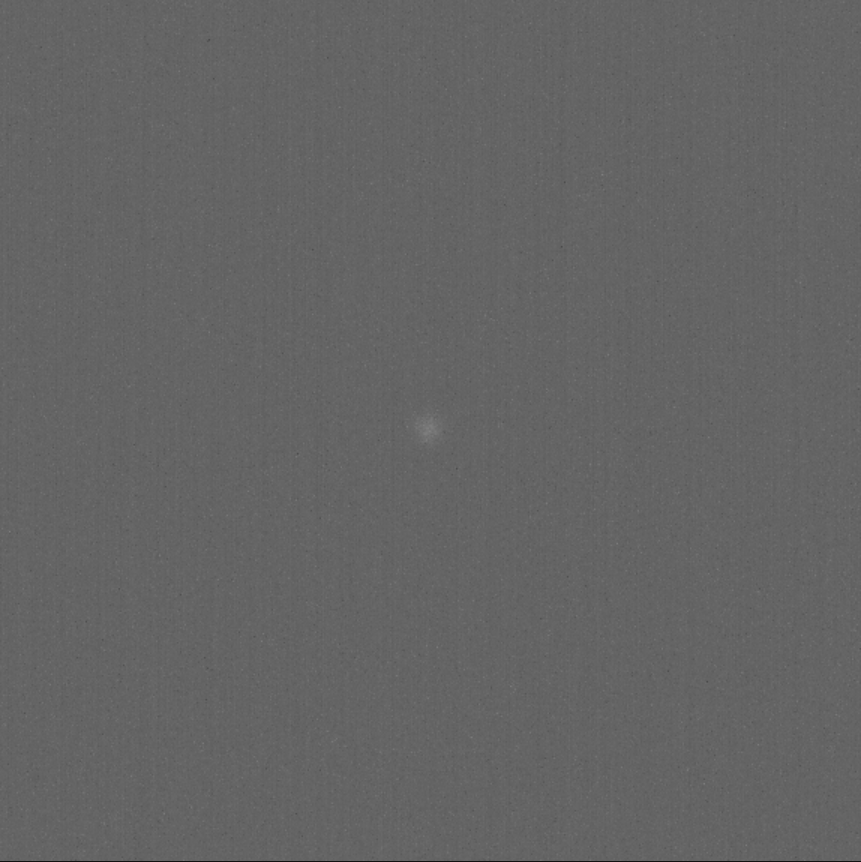

(576, 576)


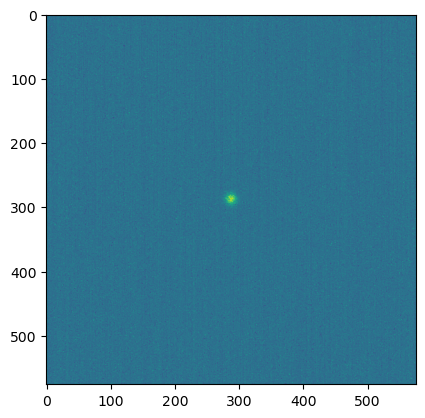

In [18]:
import numpy as np
import PIL
import matplotlib.pyplot as plt


image = PIL.Image.open(input_files[0])
imagenp= np.array(image)
print (imagenp.shape)
plt.imshow(imagenp)
plt.show()

## Exercise 3a - Define a function to compute the histogram of a single figure - ⌛⌛
The image we have plotted above, shows clearly that the contrast is not optimal.
However, this might be due to the fact that the contrast of that single image is indeed suboptimal, or rather that the whole sample is shrinked in a subset of the 256 possible values.

To discover in which of these different situations we are in, let's build a histogram of the pixel values of the whole dataset (and not of a single image).

We start gently defining a function that takes as an input the filename and provides as an output the counts of the pixel values in the range 0 to 255.

> 💡**Hint.** You may want to use the following numpy functions (click for the docs):
> * [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) creates an array of equidistant values in a specified range
> * [`np.histogram`](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) computes the number of entries in (possibly user-defined) bins
> * [`np.array.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) unroll a multidimensional array to get a 1D array with the same (now unstructured) content

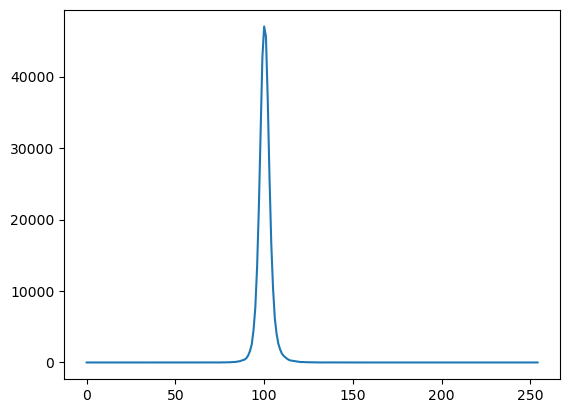

In [19]:
## Solution
def compute_pixel_hist(filename):
    """
    Compute and return the histograms of the pixel values of filename, 
    one bin per pixel value in range 0-255.
    """
    np_image = np.array(PIL.Image.open(input_files[0]))
    boundaries = np.linspace(-0.5, 255.5, 256)
    contents, _ = np.histogram(np_image.flatten(), bins=boundaries)
    return contents

## Example
compute_pixel_hist(input_files[0]).shape
contents=compute_pixel_hist(input_files[0])
plt.plot(contents)

## Exercise 3b - Obtain and draw the histogram for the whole dataset - ⌛⌛
Loop on all the file names obtained from the downloaded archive and, for each of them, compute the histogram.
Then sum all of the histograms contents together to obtain the histogram of the whole image dataset.
Draw it.

> 💡**Hint.** You may want to use [`plt.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) to draw this histogram instead of [`np.hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html). Indeed, [`np.hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) "computes and displays" the histogram, while in this case, you have computed the histogram altready and you just need to show it.

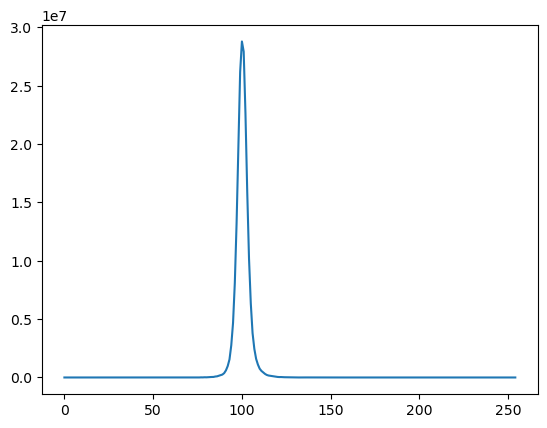

In [20]:
histsomma=0
for input in input_files:
    histsomma+=compute_pixel_hist(input)

plt.plot(histsomma)
plt.show()

## Exercise 4 - Windowing and conversion to float - ⌛
Define a function taking as an input the numpy-converted image and two values for the minimal and maxmal brightness and returning a rescaled value of each pixel ito fit that range into the interval [0, 1].

Obtain minam and maxima brightness from the histogram drawn in Exercise 3.

Try to visualize the image obtained from this preprocessing.

> 💡**Hint.** A skeleton of the solution might be:
> ```python
> def windowing(np_image, x_min, x_max):
>   """Maps the pixel values from the interval [x_min, x_max] to [0, 1]"""
>   ... your code here ...
>
> plt.imshow(windowing(np_image, ... your values here ...), cmap='gray')
> ```

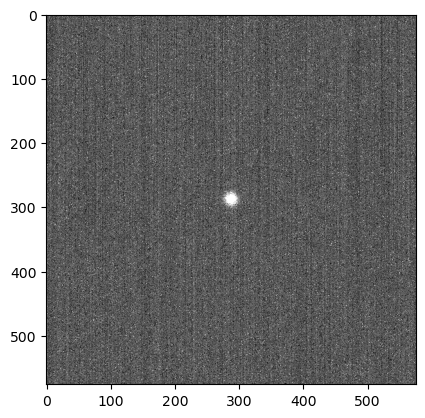

In [21]:
def windowing(np_image, x_min, x_max):
    cp_img = (np_image-x_min)/(x_max-x_min)
    fin_img=np.clip(cp_img,0,1)
    return fin_img

image = PIL.Image.open(input_files[0])
np_image= np.array(image)
a=windowing(np_image, 95 , 120)
plt.imshow(windowing(np_image, 90. , 120.), cmap='gray')
plt.show()

## Exercise 5 - Define a function cropping the inner part of the image - ⌛⌛
Define a function `crop_center` taking as input a numpy-image and `half_win` and return a squared numpy-image of side `2*half_win` centered on the center of the input image.

In other words, if the center of the input image is `(x0, y0)` you should return a portion of the original figure identified by the bounding box 
`(x0 - half_win, y0 - half_win), (x0 + half_win, y0 + half_win)`.

> A skeleton of the solution might be:
> ```python
> def crop_center(np_image, half_win=64):
>   """Crop a numpy-represented image around its center, the resulting image will be a square of side 2*half_win"""
>   ... your code here ...
>
> plt.imshow(crop_center(np_image), cmap='gray')
> ```

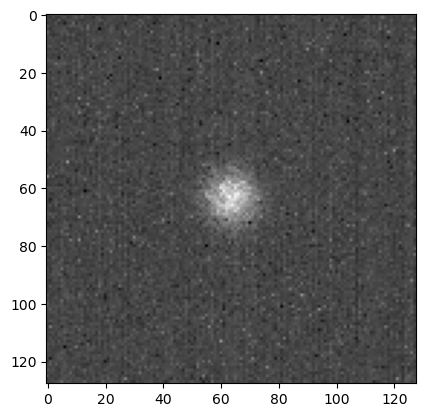

In [22]:
def crop_center(np_image, half_win=64):
    """Crop a numpy-represented image around its center, the resulting image will be a square of side 2*half_win"""
    x0=int(np_image.shape[0]/2)
    y0=int(np_image.shape[1]/2)
    return np_image[(x0-half_win):(x0+half_win),(y0-half_win):(y0+half_win)]



image = PIL.Image.open(input_files[0])
np_image= np.array(image)
#crop_center(np_image)
plt.imshow(crop_center(np_image), cmap='gray')

## Exercise 6 - Define a function cropping the inner part of the image - ⌛⌛⌛
Apply the preprocessing steps (windowing and crop) to five images for nuclear recoil and five images for electronic recoil and plot them.

<BIG>🔮</BIG> You may expect a figure similar to the following one, where the nuclear recoil is represented in blue and the electronic recoil in pink.
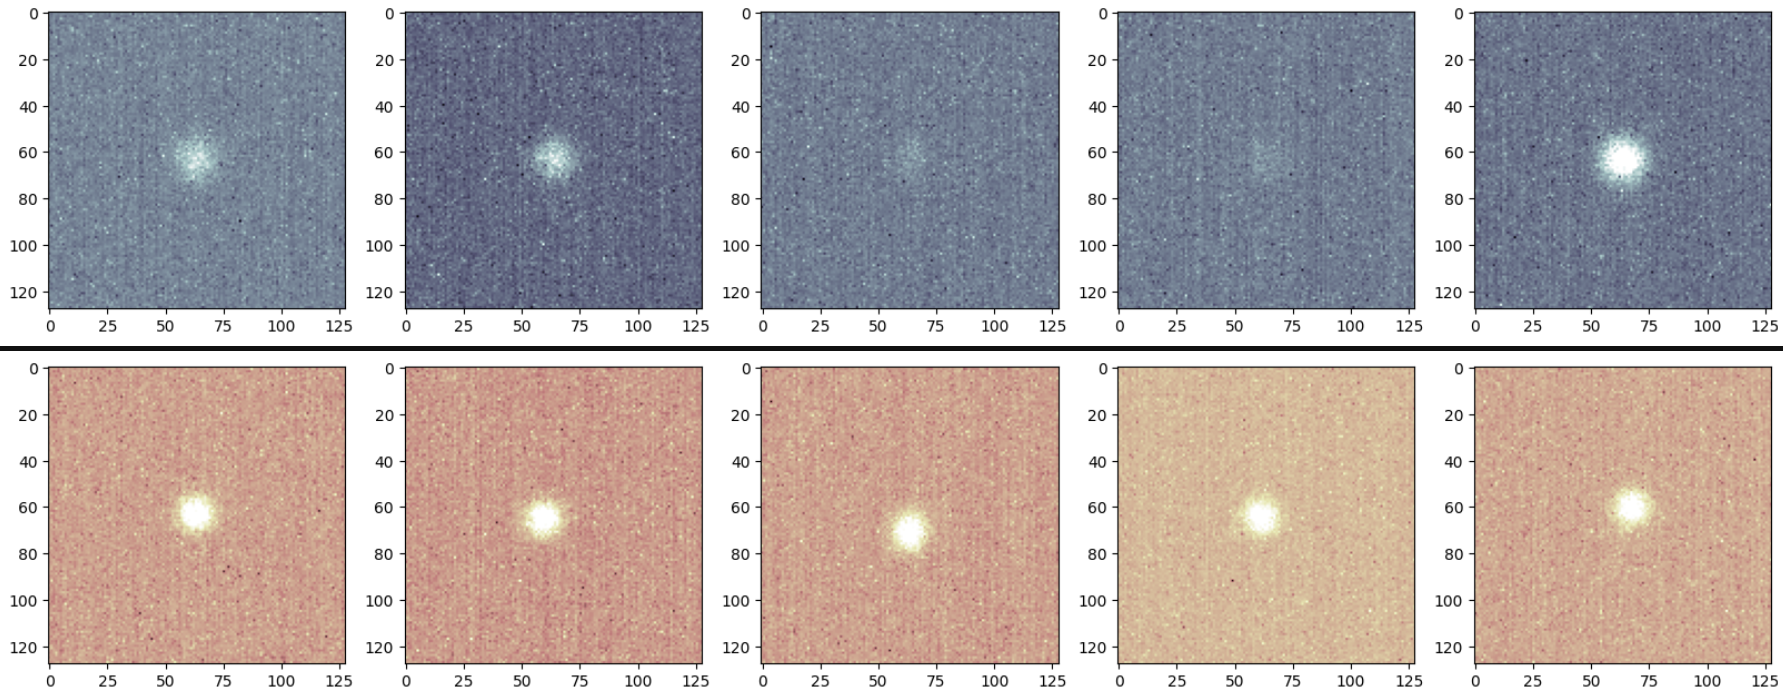



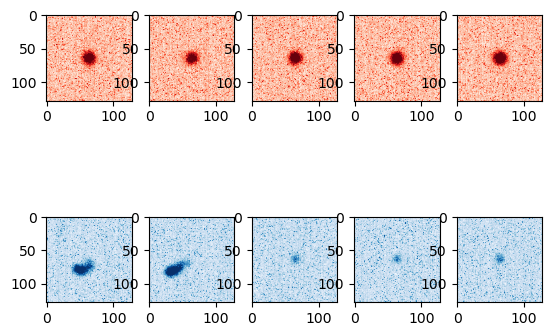

In [23]:
ERcount=0
NRcount=0
listNR=[]
listER=[]
for file in input_files:

    if ERcount>5 and NRcount>5:
        break
    
    if get_recoil_type(file)=='nuclear':
        if NRcount>4:
            continue
            
        NRcount+=1
        #print('nu')
        np_image = np.array(PIL.Image.open(file))
        np_image=windowing(np_image, 95 , 120)
        np_image=crop_center(np_image)
        listNR.append(np_image)
        
    elif get_recoil_type(file)=='electronic':
        if ERcount>4:
            continue
            
        ERcount+=1
        np_image = np.array(PIL.Image.open(file))
        np_image=windowing(np_image, 95 , 120)
        np_image=crop_center(np_image)
        listER.append(np_image)
     
i=1
for el in listNR:
    plt.subplot(2,5,i)
    plt.imshow(el, cmap='Reds')
    i+=1
for el in listER:
    plt.subplot(2,5,i)
    plt.imshow(el, cmap='Blues')
    i+=1

## Exercise 6 - Let's write our Dockerized, automated preprocessing step - ⌛⌛⌛⌛⌛

Now that we have developed our preprocessing step, we want to get ready to deploy it in front of the data acquisition pipeline.
Each new image that will be made available to us must be preprocessed before we can treat it in any meaningful way.

In this exercise we will pack the preprocessing step developed above in a dedicated cell (for order sake), then we will run a python script to look for data appearing in the input folder.

The practical steps we will follow here we create a Python library with the functions we have developed in this notebook.

### Ex. 6.5 - Create your output folder


In [24]:
%%bash
mkdir -p /home/jovyan/data/output
mkdir -p /home/jovyan/data/output/NR
mkdir -p /home/jovyan/data/output/ER
mkdir -p /home/jovyan/data/output/NR/1_keV
mkdir -p /home/jovyan/data/output/NR/10_keV
mkdir -p /home/jovyan/data/output/NR/20_keV
mkdir -p /home/jovyan/data/output/NR/3_keV
mkdir -p /home/jovyan/data/output/NR/30_keV
mkdir -p /home/jovyan/data/output/NR/6_keV
mkdir -p /home/jovyan/data/output/ER/1_keV
mkdir -p /home/jovyan/data/output/ER/10_keV
mkdir -p /home/jovyan/data/output/ER/20_keV
mkdir -p /home/jovyan/data/output/ER/3_keV
mkdir -p /home/jovyan/data/output/ER/30_keV
mkdir -p /home/jovyan/data/output/ER/6_keV

### Ex. 6.6 - Create your main script

Now you have all that you need to run your script: an environent defined in docker; a tested library with the numerical computations implemented; volumes for input and output data. 

You just need the script 😜😜😜

Create a directory `scripts` and a put a file in the directory named for example `pp_scripts/preprocessing_step.py`.

Define the following logics in this file:
 1. Create an infinite `while` loop;
 2. Make sure looping does not consume all your CPU spinning on no-ops by introducing a pause of few tens of milliseconds using [`time.sleep`](https://docs.python.org/3.11/library/time.html#time.sleep).
 3. Use [`glob.glob`](https://docs.python.org/3.11/library/glob.html#glob.glob) to loop over the PNG files in the `/input` folder;
 4. For each absolute file name detected in the `/input` folder:
       * load the image with `pillow`
       * apply the `crop_center` and `windowing` functions as defined in your `cygno_preprocessing` module
       * drop the absolute path from the file name to retrieve the "base file name" and its extension (check [`os.path.basename`](https://docs.python.org/3/library/os.path.html#os.path.basename))
       * store the preprocessed image in the `/output` folder, with the same "base name" as the original file;
       * remove the original file (you may want to check the [`os.remove`](https://docs.python.org/3/library/os.path.html#os.remove) method)



> 💡**Hint.** Your next cell may look like
> ```python
>   for image_file in  # ... your call to glob method
>      # ... your preprocessing steps
>      # ... your procedure to store the file in /output
>      os.remove(image_file)
>```

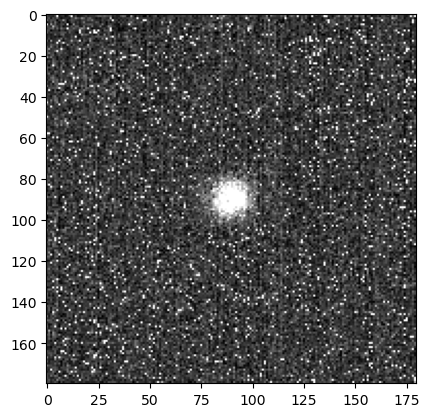

In [26]:
from glob import glob
import os
import PIL

def preprocessing_step(image):
    np_image = np.array(image)
    np_image=windowing(np_image, 95 , 120)
    np_image=crop_center(np_image,half_win=90)
    return np_image

input_files = glob ("/home/jovyan/data/export/train/*/*/*.png")
for file in input_files:
    image = PIL.Image.open(file)
    np_image= preprocessing_step(image)
    path=os.path.abspath(file)
    pathpart=path.split('/')
    newpath=pathpart[0]+'/'+pathpart[1]+'/'+pathpart[2]+'/'+pathpart[3]+'/output/'+pathpart[6]+'/'+pathpart[7]+'/'+pathpart[8]
    plt.imshow(np_image, cmap='gray')
    plt.savefig(newpath)

In [10]:
from glob import glob
import os
input_files = glob ("/home/jovyan/data/export/train/*/*/*.png")
path=os.path.abspath(input_files[200])
pathpart=path.split('/')
newpath=pathpart[0]+'/'+pathpart[1]+'/'+pathpart[2]+'/'+pathpart[3]+'/output/'+pathpart[6]+'/'+pathpart[7]+'/'+pathpart[8]
print(path)
print(newpath)

/home/jovyan/data/export/train/NR/6_keV/cygno-0080.png
/home/jovyan/data/output/NR/6_keV/cygno-0080.png


## Execute the notebook in background


Papermill is a convenient tool to execute a notebook in the background. Open a terminal and try it out:

```bash
papermill  Project-Day1.ipynb  ./outputs/output-Day1.ipynb --no-progress-bar
```

You can also execute it in the background without waiting for it to finish:

```bash
papermill  Project-Day1.ipynb  ./outputs/output-Day1.ipynb --no-progress-bar > /tmp/log 2>&1
```

In [ ]:
#tried on terminal and worked after creating the outputs folder and the coomand is
#papermill --no-progress-bar 02-Project-Day1.ipynb  ./outputs/output-Day1.ipynb 